# Download data

In [1]:
import os
import zipfile
import kaggle
# use kaggle api to download the data or manully download the data urself
## ! Kaggle competitions download -c "jane-street-real-time-market-data-forecasting" 

# make the directory to be "data/jane-street-real-time-market-data-forecasting" and extract file there u f the code dont work do it manually
## os.makedirs("data/jane-street-real-time-market-data-forecasting", exist_ok=True) # create directory for jane-street-real-time-market-data-forecasting-housing
## !unzip jane-street-real-time-market-data-forecasting.zip -d data/jane-street-real-time-market-data-forecasting/

# Kaggle Competition 

In [2]:
import numpy as np
import pandas as pd
import polars as pl

In [3]:
train_data = pd.read_parquet("data/train_data.parquet")

In [4]:
train_data.shape

(11774752, 101)

In [5]:
val_data = pd.read_parquet("data/validate_data.parquet")

In [6]:
val_data.shape

(639848, 101)

## Data cleaning

In [7]:
# feature selection ## select every feature except 0-4 
# feature_cols = ["symbol_id", "time_id"] + [f"feature_{idx:02d}" for idx in range(79)]+ [f"responder_{idx}_lag_1" for idx in range(9)]
feature_cols = [f"feature_{idx:02d}" for idx in range(79)]+ [f"responder_{idx}_lag_1" for idx in range(9)]

#select target values
target_cols = ["responder_6"]

# select the weight values
weight_cols = ["weight"]

## drop the other responder column

In [8]:
from sklearn.preprocessing import MinMaxScaler

ScaleX =    MinMaxScaler(feature_range=(-1,1)).fit(train_data[feature_cols])
ScaleY =    MinMaxScaler(feature_range=(-1,1)).fit(train_data[target_cols])

In [9]:
# the chunk requir maximum memory
X_train =   ScaleX.transform(train_data[feature_cols])
y_train =   ScaleY.transform(train_data[target_cols])
w_train =   train_data[weight_cols]
X_val =     ScaleX.transform(val_data[feature_cols])    
y_val =     val_data[target_cols]
w_val =     val_data[weight_cols]

In [10]:
y_train.min(), y_train.max()

(-1.0, 1.0)

In [11]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

In [12]:
# Sample a subset of the data
sample_fraction = 1000  # Adjust this fraction as needed
i = 3001
X_train_sampled = X_train[sample_fraction*i:sample_fraction*(i+1)]
y_train_sampled = y_train[sample_fraction*i:sample_fraction*(i+1)]
w_train_sampled = w_train[sample_fraction*i:sample_fraction*(i+1)]
X_train_sampled.shape, y_train_sampled.shape, w_train_sampled.shape

((1000, 88), (1000, 1), (1000, 1))

In [13]:
# state the search
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8 , 9, 10, 11],
    'n_estimators': [100, 200, 300, 500, 1000],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1, 10, 100],
    'reg_lambda': [0, 0.01, 0.1, 1, 10, 100],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
}

#define the model
model  = XGBRegressor(random_state = 42 , device = 'cuda')

# define grid_search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=1000, cv=5, scoring='r2', verbose=1, n_jobs=-1, random_state=42)

# do the grid search
random_search.fit(X_train_sampled, y_train_sampled, sample_weight = w_train_sampled)

# Get the best parameters and evaluate the model
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best parameters found: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}


In [14]:
# Create the XGBRegressor model with the specified parameters
model = XGBRegressor(**best_params, random_state = 42 , device = 'cuda')

# Fit the model to the training data
model.fit(X_train, y_train,sample_weight=w_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [20]:
pred = model.predict(X_val)
pred_inverse = ScaleY.inverse_transform(pred.reshape(-1, 1))
r2 = r2_score(y_val, pred_inverse, sample_weight=w_val)
print(f"R2 score: {r2:.6f}")

R2 score: 0.006667


In [21]:
pred_inverse.min(), pred_inverse.max()

(-1.7485456, 4.869494)

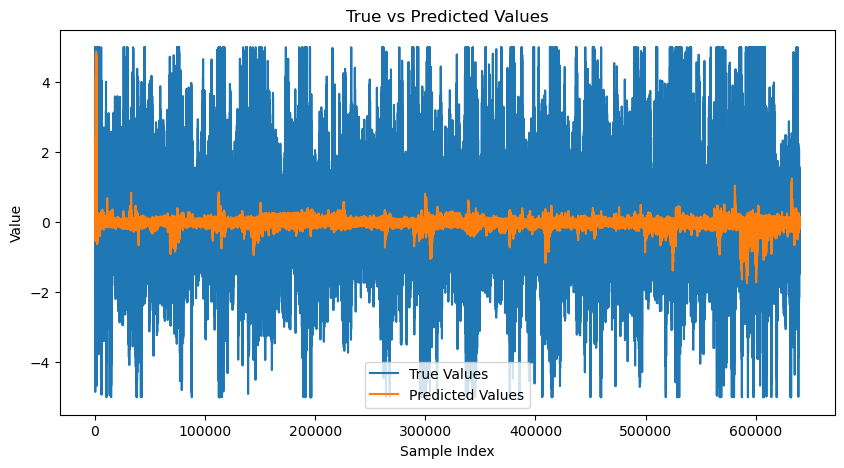

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(y_val.reset_index(drop =True), label='True Values')
plt.plot(pred_inverse, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [23]:
def validate_n_fold(model,X_val, y_val,w_val, n_folds):
    global ScaleY
    batch_size = len(y_val)//n_folds    
    for i in range(0, len(X_val), batch_size):
        X_batch = X_val[i:i+batch_size]
        y_batch = y_val[i:i+batch_size]
        w_batch = w_val[i:i+batch_size]
        preds = model.predict(X_batch)
        pred_inverse = ScaleY.inverse_transform(preds.reshape(-1, 1))
        score1 = r2_score(y_batch, pred_inverse ,sample_weight= w_batch)
        print(f'Batch {i//batch_size} r2_score: {score1:.6f}')

In [24]:
validate_n_fold(model,X_val, y_val, w_val, 10)

Batch 0 r2_score: 0.021565
Batch 1 r2_score: 0.006218
Batch 2 r2_score: 0.004280
Batch 3 r2_score: 0.010372
Batch 4 r2_score: 0.000401
Batch 5 r2_score: 0.002531
Batch 6 r2_score: 0.007116
Batch 7 r2_score: 0.003840
Batch 8 r2_score: 0.007261
Batch 9 r2_score: -0.000129
Batch 10 r2_score: -0.738728


# save data

In [25]:
import joblib
# save
joblib.dump(model, "model/XGBoost_test6.pkl") 

['model/XGBoost_test6.pkl']

In [ ]:
joblib.dump(ScaleX, "model/XGBoost_scaleX.pkl")
joblib.dump(ScaleY, "model/XGBoost_scaleY.pkl")

In [25]:
# best model
best_model = joblib.load("model/XGBoost_best_model.pkl")

In [29]:
Best_pred = best_model.predict(X_val)
Best_pred_inverse = ScaleY.inverse_transform(Best_pred.reshape(-1, 1))
r2 = r2_score(y_val, Best_pred_inverse, sample_weight=w_val)
print(f"R2 score: {r2:.6f}")

R2 score: 0.006334


In [30]:
validate_n_fold(best_model,X_val, y_val, w_val, 10)

Batch 0 r2_score: 0.020093
Batch 1 r2_score: 0.006747
Batch 2 r2_score: 0.004269
Batch 3 r2_score: 0.012196
Batch 4 r2_score: -0.000069
Batch 5 r2_score: 0.000166
Batch 6 r2_score: 0.006308
Batch 7 r2_score: 0.003994
Batch 8 r2_score: 0.006539
Batch 9 r2_score: 0.000604
Batch 10 r2_score: -0.915643
